In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### İstanbul yıllara göre nüfus bilgisi

In [9]:
nufus=[13624240,13854740,14160467,14377018, 14657434,14804116,15029231,15067724,15519267,15462452,15840900,15907951]

In [10]:
pop=pd.DataFrame({"population":nufus}, index=range(2011,2023))

In [11]:
pop["population"]=pop["population"].astype(float)

In [12]:
pop

,population
2011,13624240.0
2012,13854740.0
2013,14160467.0
2014,14377018.0
2015,14657434.0
2016,14804116.0
2017,15029231.0
2018,15067724.0
2019,15519267.0
2020,15462452.0


# İstanbul barajları ortalama doluluk oranları ve yağış, tüketim, temiz su datası

In [13]:
df=pd.read_csv("baraj3.csv", encoding='latin-1', on_bad_lines='skip', sep=";")


In [14]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Ãmerli,Darlik,Elmali,Terkos,Alibey,BÃ¼yÃ¼kÃ§ekmece,Sazlidere,Kazandere,PabuÃ§dere,Istrancalar,ort,yagis,tuketim,temiz
0,1.01.11,1.01.11 00:00,"80,07","84,86","96,25","91,87","42,48","85,99","79,1","93,9","94,19","99,99","84,87",0,NaN,65.178
1,2.01.11,2.01.11 00:00,"80,07","85,02","96,67","91,68","42,71","86,17","79,21","92,8","93,11","99,99","84,74",0,NaN,65.178
2,3.01.11,3.01.11 00:00,"80,07","85,07","96,88","91,68","42,79","86,55","79,31","91,39","91,71","99,99","84,54","0,78",NaN,65.178
3,4.01.11,4.01.11 00:00,"80,07","85,18",95,"92,44","43,34","86,74","79,96","90,65","90,99","99,99","84,44","11,66",NaN,65.178
4,5.01.11,5.01.11 00:00,"80,61","85,98","95,21","92,63","45,81","87,3","80,37","90,93","91,26","99,99","85,01","3,81",NaN,65.178


In [15]:

from datetime import datetime
df.index=pd.date_range("2011-01-01","31-03-23")

In [16]:
df.rename(columns ={"Ãmerli":"Omerli", "BÃ¼yÃ¼kÃ§ekmece":"Buyukcekmece", "PabuÃ§dere":"Pabucdere","ort":"ort_dol", "yagis":"ort_yagis",
                    "tuketim":"ort_tuketim"}, inplace=True)

In [17]:
df.drop(["Unnamed: 0.1", "Unnamed: 0"], 1, inplace=True)

In [18]:
from datetime import datetime
df.index=pd.date_range("2011-01-01","31-03-23")

In [19]:
for i in df.columns:
    try:
        df[i]=df[i].apply(lambda x: x.replace(",","."))
    except:
        pass

In [20]:
for i in df.columns:
    try:
        df[i]=df[i].astype(float)
    except:
        pass

In [21]:
df.loc["2011","ort_tuketim"]=13487570.79
df.loc["2012","ort_tuketim"]=14049552.91
df.loc["2013","ort_tuketim"]=14634950.95
df.loc["2014","ort_tuketim"]=15244740.57

In [22]:
df["population"]=np.nan

In [23]:
for i in range(2011-2023):
    df.loc[str(i),"population"]=pop.loc[i,"population"]

In [24]:
df.loc["2011","population"]=pop.loc[2011,"population"]
df.loc["2012","population"]=pop.loc[2012,"population"]
df.loc["2013","population"]=pop.loc[2013,"population"]
df.loc["2014","population"]=pop.loc[2014,"population"]
df.loc["2015","population"]=pop.loc[2015,"population"]
df.loc["2016","population"]=pop.loc[2016,"population"]
df.loc["2017","population"]=pop.loc[2017,"population"]
df.loc["2018","population"]=pop.loc[2018,"population"]
df.loc["2019","population"]=pop.loc[2019,"population"]
df.loc["2020","population"]=pop.loc[2020,"population"]
df.loc["2021","population"]=pop.loc[2021,"population"]
df.loc["2022","population"]=pop.loc[2022,"population"]
df.loc["2023","population"]=pop.loc[2022,"population"]

In [25]:
df.head()

,Omerli,Darlik,Elmali,Terkos,Alibey,Buyukcekmece,Sazlidere,Kazandere,Pabucdere,Istrancalar,ort_dol,ort_yagis,ort_tuketim,temiz,population
2011-01-01,80.07,84.86,96.25,91.87,42.48,85.99,79.10,93.90,94.19,99.99,84.87,0.00,13487570.79,65.178,13624240.0
2011-01-02,80.07,85.02,96.67,91.68,42.71,86.17,79.21,92.80,93.11,99.99,84.74,0.00,13487570.79,65.178,13624240.0
2011-01-03,80.07,85.07,96.88,91.68,42.79,86.55,79.31,91.39,91.71,99.99,84.54,0.78,13487570.79,65.178,13624240.0
2011-01-04,80.07,85.18,95.00,92.44,43.34,86.74,79.96,90.65,90.99,99.99,84.44,11.66,13487570.79,65.178,13624240.0
2011-01-05,80.61,85.98,95.21,92.63,45.81,87.30,80.37,90.93,91.26,99.99,85.01,3.81,13487570.79,65.178,13624240.0


In [26]:
df=df.iloc[:,10:]

In [27]:
df.head()

,ort_dol,ort_yagis,ort_tuketim,temiz,population
2011-01-01,84.87,0.00,13487570.79,65.178,13624240.0
2011-01-02,84.74,0.00,13487570.79,65.178,13624240.0
2011-01-03,84.54,0.78,13487570.79,65.178,13624240.0
2011-01-04,84.44,11.66,13487570.79,65.178,13624240.0
2011-01-05,85.01,3.81,13487570.79,65.178,13624240.0


In [28]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [30]:
def add_lags(df):
    target_map = df['ort_dol'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

In [31]:
df["dayofweek"]=df["dayofweek"].apply(lambda x: x+1)

In [32]:
df.head()

,ort_dol,ort_yagis,ort_tuketim,temiz,population,dayofweek,month,year,dayofyear,dayofmonth,quarter,weekofyear,lag1,lag2,lag3
2011-01-01,84.87,0.00,13487570.79,65.178,13624240.0,6,1,2011,1,1,1,52,NaN,NaN,NaN
2011-01-02,84.74,0.00,13487570.79,65.178,13624240.0,7,1,2011,2,2,1,52,NaN,NaN,NaN
2011-01-03,84.54,0.78,13487570.79,65.178,13624240.0,1,1,2011,3,3,1,1,NaN,NaN,NaN
2011-01-04,84.44,11.66,13487570.79,65.178,13624240.0,2,1,2011,4,4,1,1,NaN,NaN,NaN
2011-01-05,85.01,3.81,13487570.79,65.178,13624240.0,3,1,2011,5,5,1,1,NaN,NaN,NaN


# Train and Test Split

In [33]:
train = df.loc[df.index < '01-01-2022']
test = df.loc[df.index >= '01-01-2022']

In [34]:
train = create_features(train)
test = create_features(test)

FEATURES = ['ort_yagis',"temiz", 'population','dayofweek', 'month', 'dayofmonth',"lag1","lag2","lag3"]
TARGET = "ort_dol"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [35]:
X_test=X_test.loc[:"2022-12-31"]
y_test=y_test.loc[:"2022-12-31"]

In [36]:
X_train["dayofweek"]=X_train["dayofweek"].apply(lambda x: str(x))
X_train["month"]=X_train["month"].apply(lambda x: str(x))
X_train["dayofmonth"]=X_train["dayofmonth"].apply(lambda x: str(x))
#X_train["quarter"]=X_train["quarter"].apply(lambda x: str(x))

X_test["dayofweek"]=X_test["dayofweek"].apply(lambda x: str(x))
X_test["month"]=X_test["month"].apply(lambda x: str(x))
X_test["dayofmonth"]=X_test["dayofmonth"].apply(lambda x: str(x))
#X_test["quarter"]=X_test["quarter"].apply(lambda x: str(x))

In [37]:
from category_encoders import TargetEncoder
te=TargetEncoder()
X_train=te.fit_transform(X_train, y_train)
X_test=te.transform(X_test)

In [38]:
X_train.head(10)

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3
2011-01-01,0.00,65.178,13624240.0,62.058153,63.530997,62.426510,NaN,NaN,NaN
2011-01-02,0.00,65.178,13624240.0,62.029808,63.530997,62.419085,NaN,NaN,NaN
2011-01-03,0.78,65.178,13624240.0,61.995157,63.530997,62.366283,NaN,NaN,NaN
2011-01-04,11.66,65.178,13624240.0,61.991707,63.530997,62.268481,NaN,NaN,NaN
2011-01-05,3.81,65.178,13624240.0,62.014826,63.530997,62.175225,NaN,NaN,NaN
2011-01-06,0.45,65.178,13624240.0,62.010941,63.530997,62.336283,NaN,NaN,NaN
2011-01-07,2.19,65.178,13624240.0,62.009059,63.530997,62.422722,NaN,NaN,NaN
2011-01-08,0.00,65.178,13624240.0,62.058153,63.530997,62.398858,NaN,NaN,NaN
2011-01-09,0.00,65.178,13624240.0,62.029808,63.530997,62.303405,NaN,NaN,NaN
2011-01-10,0.00,65.178,13624240.0,61.995157,63.530997,62.199316,NaN,NaN,NaN


In [39]:
y_train.head()

2011-01-01    84.87
2011-01-02    84.74
2011-01-03    84.54
2011-01-04    84.44
2011-01-05    85.01
Freq: D, Name: ort_dol, dtype: float64

In [40]:
len(X_train), len(y_train)

(4018, 4018)

In [41]:
X_test.head(10)

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3
2022-01-01,0.06,88.812,15907951.0,62.058153,63.530997,62.426510,19.52,35.72,86.50
2022-01-02,1.21,88.812,15907951.0,62.029808,63.530997,62.419085,19.51,35.57,87.66
2022-01-03,0.85,88.812,15907951.0,61.995157,63.530997,62.366283,19.48,35.16,87.91
2022-01-04,0.00,88.812,15907951.0,61.991707,63.530997,62.268481,19.45,40.78,87.76
2022-01-05,0.00,88.812,15907951.0,62.014826,63.530997,62.175225,19.42,46.71,87.15
2022-01-06,0.00,88.812,15907951.0,62.010941,63.530997,62.336283,19.36,47.70,86.61
2022-01-07,0.00,88.812,15907951.0,62.009059,63.530997,62.422722,19.33,48.52,87.86
2022-01-08,4.16,88.812,15907951.0,62.058153,63.530997,62.398858,19.29,48.66,90.43
2022-01-09,0.46,88.812,15907951.0,62.029808,63.530997,62.303405,20.24,48.59,91.24
2022-01-10,0.25,88.812,15907951.0,61.995157,63.530997,62.199316,26.36,48.46,90.58


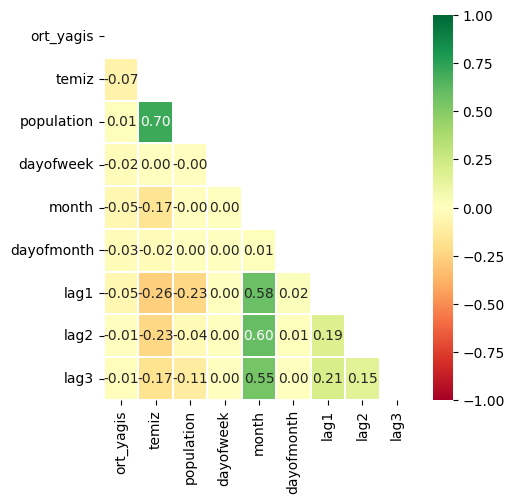

In [42]:
plt.figure(figsize=(5,5))
sns.heatmap(X_train.corr(), annot=True, vmin=-1, center=0, vmax=1, fmt=".2f",mask=np.triu(X_train.corr()),linewidths=0.3, cmap='RdYlGn');

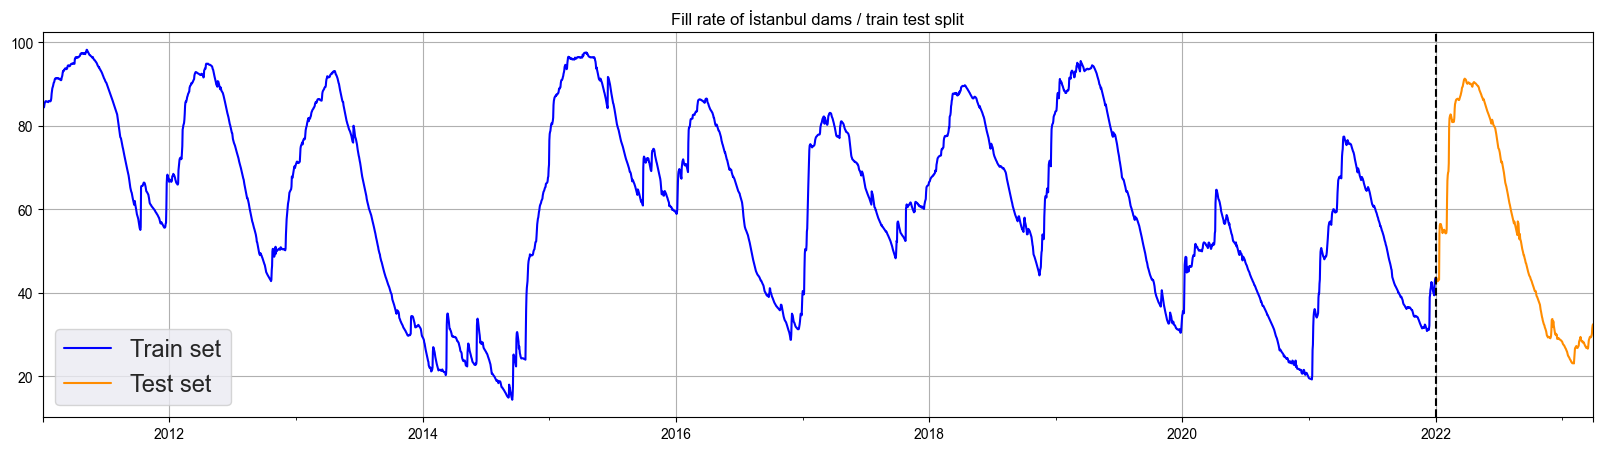

In [43]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style("darkgrid")
train["ort_dol"].plot(ax=ax,label='Train', title='Fill rate of İstanbul dams / train test split',color="blue")
test["ort_dol"].plot(ax=ax, label='Test', color="darkorange")
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Train set', 'Test set'], fontsize="17")
plt.show()

# Modelling with XGBRegressor

In [44]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [45]:
from xgboost import XGBRegressor
xgb= XGBRegressor(objective= 'reg:linear',
 n_estimators= 4000,
 max_depth= 3,
 learning_rate= 0.1,
 booster= 'gbtree',
 base_score= 2)
xgb.fit(X_train, y_train)

[14:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=2, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=4000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [46]:
y_pred=xgb.predict(X_test)

In [47]:
tablo=pd.DataFrame({"y":y_test, "y_hat":y_pred}, index=X_test.index)

## Estimate on Test data

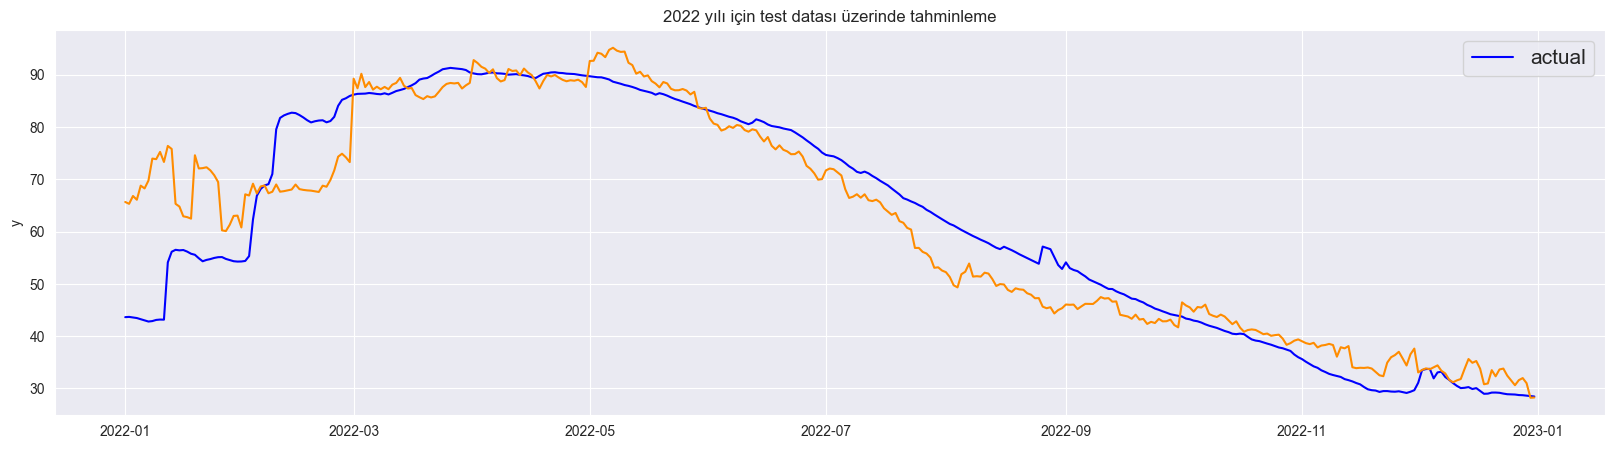

In [48]:
plt.figure(figsize=(20,5))
sns.set_style("darkgrid")
sns.lineplot(tablo, x=tablo.index, y="y", color="blue")
sns.lineplot(tablo, x=tablo.index, y="y_hat", color="darkorange")
plt.title("2022 yılı için test datası üzerinde tahminleme")
plt.legend(["actual"], fontsize="15")
plt.show()

In [49]:
print(f"train score: {round(xgb.score(X_train, y_train),4)}")
print(f"test score: {round(xgb.score(X_test, y_test),4)}")
print("---------------------------------------")
print(f"mae: {round(mean_absolute_error(y_test, y_pred),2)}")
print(f"mse: {round(mean_squared_error(y_test, y_pred),2)}")
print(f"rmse:{round(np.sqrt(mean_squared_error(y_test, y_pred)),2)}")
print(f"mape: {round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100,2)}")

train score: 0.9996
test score: 0.8778
---------------------------------------
mae: 5.29
mse: 57.34
rmse:7.57
mape: 9.9


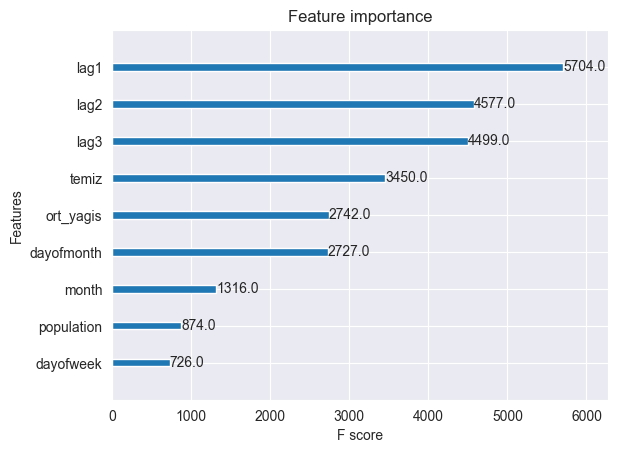

In [50]:
from xgboost import plot_importance
plot_importance(xgb);

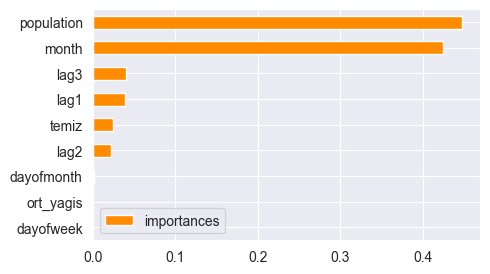

In [51]:
TAB=pd.DataFrame({"importances":xgb.feature_importances_}, index=X_train.columns)
TAB.sort_values(by="importances").plot(kind="barh", color="darkorange",figsize=(5,3));

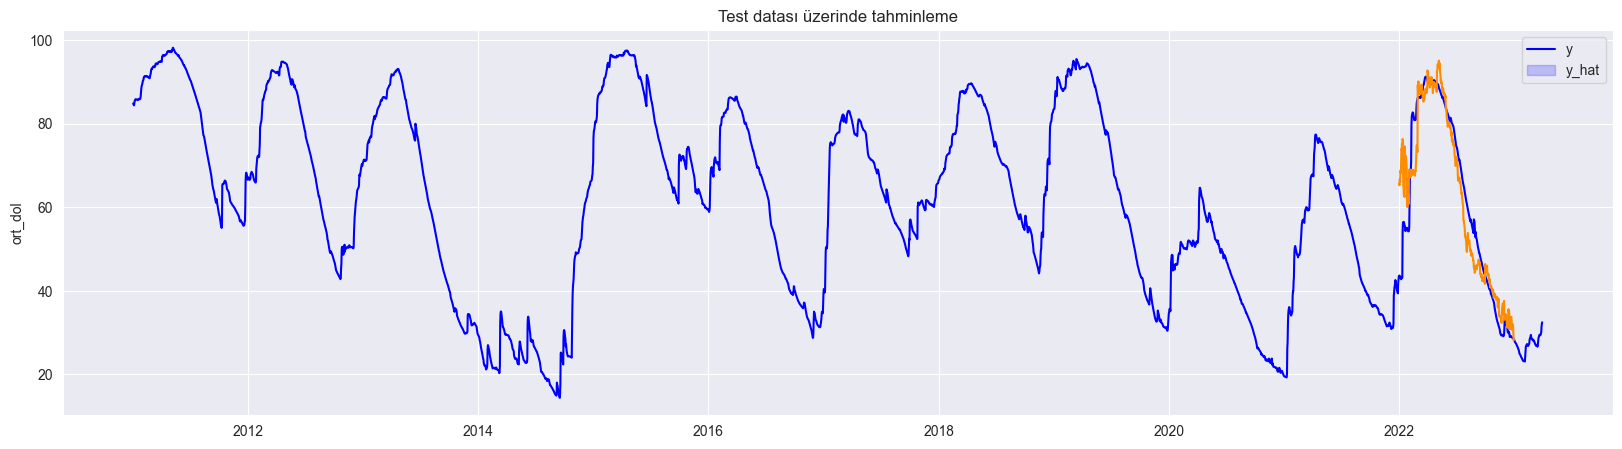

In [52]:
plt.figure(figsize=(20,5))
sns.set_style("darkgrid")
sns.lineplot(df, x=df.index, y="ort_dol", color="b")
sns.lineplot(tablo, x=tablo.index, y="y_hat", color="darkorange")
plt.title("Test datası üzerinde tahminleme")
plt.legend(["y","y_hat"]);

# 2023 nisan - 2024 nisan dönemi için geleceğe yönelik tahminleme

In [53]:
df.head()

,ort_dol,ort_yagis,ort_tuketim,temiz,population,dayofweek,month,year,dayofyear,dayofmonth,quarter,weekofyear,lag1,lag2,lag3
2011-01-01,84.87,0.00,13487570.79,65.178,13624240.0,6,1,2011,1,1,1,52,NaN,NaN,NaN
2011-01-02,84.74,0.00,13487570.79,65.178,13624240.0,7,1,2011,2,2,1,52,NaN,NaN,NaN
2011-01-03,84.54,0.78,13487570.79,65.178,13624240.0,1,1,2011,3,3,1,1,NaN,NaN,NaN
2011-01-04,84.44,11.66,13487570.79,65.178,13624240.0,2,1,2011,4,4,1,1,NaN,NaN,NaN
2011-01-05,85.01,3.81,13487570.79,65.178,13624240.0,3,1,2011,5,5,1,1,NaN,NaN,NaN


In [54]:
from datetime import datetime
future=pd.date_range("2023-04-01","2024-03-31")

In [55]:
future=future.to_frame()

In [56]:
future["target"]=True

In [57]:
future.drop(0,1,inplace=True)

In [58]:
future.head()

,target
2023-04-01,True
2023-04-02,True
2023-04-03,True
2023-04-04,True
2023-04-05,True


In [59]:
df["target"]=False

In [60]:
df_and_future=pd.concat([df, future])

In [61]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [62]:
df_and_future.head()

,ort_dol,ort_yagis,ort_tuketim,temiz,population,dayofweek,month,year,dayofyear,dayofmonth,quarter,weekofyear,lag1,lag2,lag3,target
2011-01-01,84.87,0.00,13487570.79,65.178,13624240.0,5,1,2011,1,1,1,52,NaN,NaN,NaN,False
2011-01-02,84.74,0.00,13487570.79,65.178,13624240.0,6,1,2011,2,2,1,52,NaN,NaN,NaN,False
2011-01-03,84.54,0.78,13487570.79,65.178,13624240.0,0,1,2011,3,3,1,1,NaN,NaN,NaN,False
2011-01-04,84.44,11.66,13487570.79,65.178,13624240.0,1,1,2011,4,4,1,1,NaN,NaN,NaN,False
2011-01-05,85.01,3.81,13487570.79,65.178,13624240.0,2,1,2011,5,5,1,1,NaN,NaN,NaN,False


In [63]:
future_w_features = df_and_future.query('target').copy()

In [64]:
future_w_features.head()

,ort_dol,ort_yagis,ort_tuketim,temiz,population,dayofweek,month,year,dayofyear,dayofmonth,quarter,weekofyear,lag1,lag2,lag3,target
2023-04-01,NaN,NaN,NaN,NaN,NaN,5,4,2023,91,1,2,13,90.12,67.56,54.30,True
2023-04-02,NaN,NaN,NaN,NaN,NaN,6,4,2023,92,2,2,13,90.09,67.44,54.81,True
2023-04-03,NaN,NaN,NaN,NaN,NaN,0,4,2023,93,3,2,14,90.23,70.23,61.61,True
2023-04-04,NaN,NaN,NaN,NaN,NaN,1,4,2023,94,4,2,14,90.40,72.75,62.98,True
2023-04-05,NaN,NaN,NaN,NaN,NaN,2,4,2023,95,5,2,14,90.44,73.80,64.69,True


In [65]:
feature=['ort_yagis',"temiz", 'population','dayofweek', 'month', 'dayofmonth',"lag1","lag2","lag3"]

In [66]:
tahmin=future_w_features[feature]

In [67]:
tahmin["dayofweek"]=tahmin["dayofweek"].apply(lambda x: str(x))
tahmin["month"]=tahmin["month"].apply(lambda x: str(x))
tahmin["dayofmonth"]=tahmin["dayofmonth"].apply(lambda x: str(x))

In [68]:
tahmin.head()

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3
2023-04-01,NaN,NaN,NaN,5,4,1,90.12,67.56,54.30
2023-04-02,NaN,NaN,NaN,6,4,2,90.09,67.44,54.81
2023-04-03,NaN,NaN,NaN,0,4,3,90.23,70.23,61.61
2023-04-04,NaN,NaN,NaN,1,4,4,90.40,72.75,62.98
2023-04-05,NaN,NaN,NaN,2,4,5,90.44,73.80,64.69


In [69]:
tahmin.dtypes

ort_yagis     float64
temiz         float64
population    float64
dayofweek      object
month          object
dayofmonth     object
lag1          float64
lag2          float64
lag3          float64
dtype: object

In [70]:
tahmin["population"]=15927951

In [71]:
yag22=list(df.loc["2022-04-01":,"ort_yagis"])

In [72]:
yag22.insert(334,0.0)

In [73]:
yag21=list(df.loc["2021-04-01":"2022-03-31","ort_yagis"])

In [74]:
yag21.insert(334,0.0)

In [75]:
yag20=list(df.loc["2020-04-01":"2021-03-31","ort_yagis"])

In [76]:
yag20.insert(334,0.0)

In [77]:
top=np.array([yag20,yag21,yag22])

In [78]:
yag=list((top[0]+top[1]+top[2])/3)

In [79]:
tahmin["ort_yagis"]=yag

In [80]:
tem=list(df.loc["2022-04-01":,"temiz"])

In [81]:
89+(89*(3.45/100))

92.0705

In [82]:
tem.insert(334,80.459)

In [83]:
temiz2=[]
for i in tem:
    temiz2.append(i+(i*(3.45/100)))

In [84]:
tahmin["temiz"]=temiz2

In [85]:
tahmin.head()

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3
2023-04-01,0.283333,90.161848,15927951,5,4,1,90.12,67.56,54.30
2023-04-02,0.353333,90.161848,15927951,6,4,2,90.09,67.44,54.81
2023-04-03,7.333333,90.161848,15927951,0,4,3,90.23,70.23,61.61
2023-04-04,1.063333,90.161848,15927951,1,4,4,90.40,72.75,62.98
2023-04-05,13.453333,90.161848,15927951,2,4,5,90.44,73.80,64.69


In [86]:
tahmin=te.transform(tahmin)

In [87]:
sc=pd.read_csv("sicaklik.csv", encoding='latin-1', on_bad_lines='skip', sep=",")
indeks=pd.date_range("2015-01-01","2023-05-14")
sc.set_index(indeks, inplace=True)
sc=sc.loc[:,["tavg","tmin","tmax"]]
sc.head()

,tavg,tmin,tmax
2015-01-01,3.2,2.6,4.0
2015-01-02,3.0,0.9,5.0
2015-01-03,3.6,-1.0,6.0
2015-01-04,7.2,4.7,9.0
2015-01-05,4.6,3.2,6.2


In [88]:
temp2=list(sc.loc["2022-04-01":"2023-03-31","tavg"])

In [89]:
temp2.insert(334,9.0)

In [90]:
tahminSıcaklık=tahmin.copy()

In [91]:
tahminSıcaklık["temp"]=temp2

In [92]:
tahmin.head()

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3
2023-04-01,0.283333,90.161848,15927951,62.058153,80.517364,62.426510,90.12,67.56,54.30
2023-04-02,0.353333,90.161848,15927951,62.029808,80.517364,62.419085,90.09,67.44,54.81
2023-04-03,7.333333,90.161848,15927951,61.995157,80.517364,62.366283,90.23,70.23,61.61
2023-04-04,1.063333,90.161848,15927951,61.991707,80.517364,62.268481,90.40,72.75,62.98
2023-04-05,13.453333,90.161848,15927951,62.014826,80.517364,62.175225,90.44,73.80,64.69


In [93]:
tahminSıcaklık.head()

,ort_yagis,temiz,population,dayofweek,month,dayofmonth,lag1,lag2,lag3,temp
2023-04-01,0.283333,90.161848,15927951,62.058153,80.517364,62.426510,90.12,67.56,54.30,17.3
2023-04-02,0.353333,90.161848,15927951,62.029808,80.517364,62.419085,90.09,67.44,54.81,15.9
2023-04-03,7.333333,90.161848,15927951,61.995157,80.517364,62.366283,90.23,70.23,61.61,13.2
2023-04-04,1.063333,90.161848,15927951,61.991707,80.517364,62.268481,90.40,72.75,62.98,10.3
2023-04-05,13.453333,90.161848,15927951,62.014826,80.517364,62.175225,90.44,73.80,64.69,10.3


In [94]:
y_pred=xgb.predict(tahmin) # 2021e kadar olan data ile

In [95]:
tablo=pd.DataFrame({"xgb":y_pred}, index=tahmin.index)
tablo.head()

,xgb
2023-04-01,74.123955
2023-04-02,74.755020
2023-04-03,76.268463
2023-04-04,77.066132
2023-04-05,75.340462


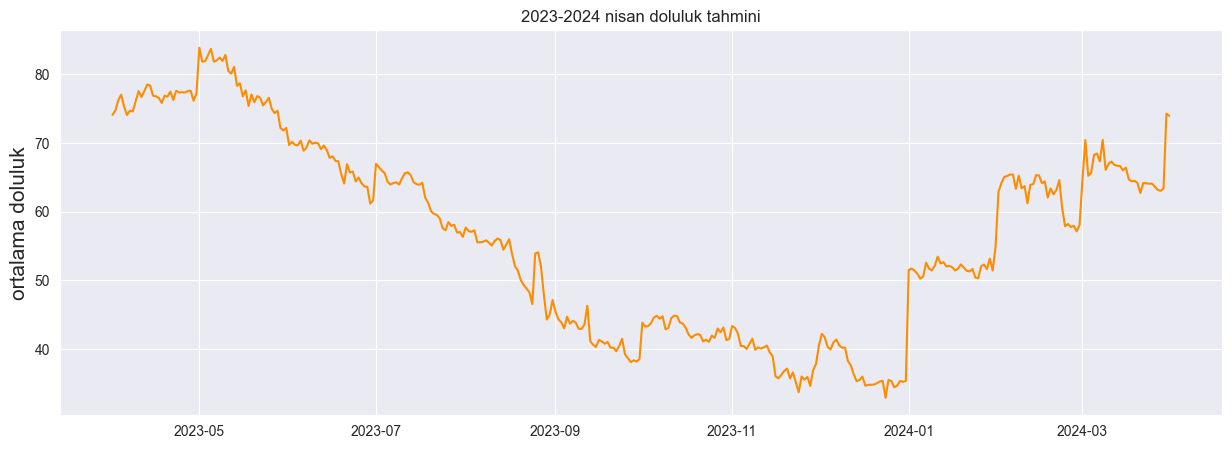

In [96]:
plt.figure(figsize=(15,5))
sns.lineplot(tablo, x=tablo.index, y="xgb", color="darkorange")
plt.ylabel("ortalama doluluk", fontsize="15")
plt.title("2023-2024 nisan doluluk tahmini");

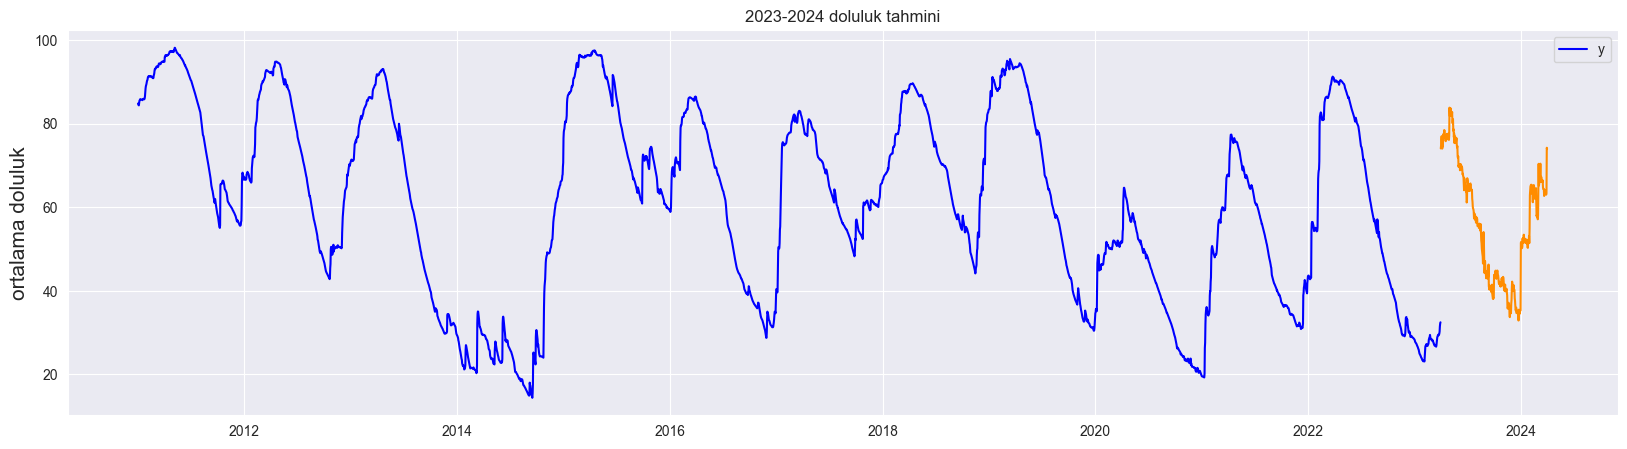

In [97]:
plt.figure(figsize=(20,5))
sns.lineplot(df_and_future, x=df_and_future.index, y="ort_dol", color="b")
sns.lineplot(tablo, x=tablo.index, y="xgb", color="darkorange")
plt.ylabel("ortalama doluluk", fontsize="15")
plt.title("2023-2024 doluluk tahmini")
plt.legend(["y"]);